In [131]:
# ML. HW01.PARKINSON DISEASE DATASET ANALYSIS, 

# Sara Joneydi
# Date loaded in elearn: جمعه بیست و ششم دیماه 1399 


In [132]:
## کتابخانه و پکیج های مورد استفاده

%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import seaborn as sns
import random 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


In [133]:
df = pd.read_csv('pd_speech_feature.csv')
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,...,0.071728,0.010352,-2.73030,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363614,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,...,0.729330,0.780410,5.22940,8643.9860,3962.0554,2976.2411,4329.0607,4005.1329,1127.6762,116.5331,20.2332,13.6395,12.5514,13.6965,60.8974,6.2958,3.0323,3.4039,4.3794,2.4329,2.0585,2.1839,2.2061,3.0999,1.9824,1.6227,1.5783,2.0470,1.5772,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.15756,0.116890,...,0.269510,-0.005522,0.35054,29.2717,32.4971,38.9453,85.1480,62.5132,9.7308,6.8890,6.1357,5.4926,3.9078,4.0864,6.9828,3.4411,3.5173,3.7204,4.2212,3.4881,3.4851,3.3007,2.0427,3.1436,2.1203,1.6627,1.6731,3.2597,1.5921,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.17295,0.147370,...,0.366920,-0.492650,0.19164,591.0116,65.3827,53.9852,45.4458,34.6650,88.3259,46.6869,23.2911,19.2022,42.3957,100.3649,7.1967,6.3892,6.5496,6.0264,4.7656,4.8909,4.2531,3.0295,2.0362,1.8478,2.5776,2.2064,1.9491,1.9120,1.8829,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.3

In [134]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [135]:
df.describe()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.000000,756.000000,756.000000,756.000000,756.00000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,125.500000,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,1.673391e-05,0.000605,0.001159,0.001815,0.067473,0.60642,0.034375,0.041175,0.055366,0.103125,0.961508,0.051131,18.859632,70.828609,76.135371,73.997008,647.174519,1233.852088,2562.425251,3547.259244,213.363237,297.174077,536.821070,506.604856,0.904423,32.295832,4.454840,1.092503,0.215038,0.144832,...,-0.041840,-0.015615,-0.005242,1059.146612,377.357439,328.927860,317.994439,305.036007,172.362746,40.408662,15.064513,12.107316,11.757945,11.871530,9.529080,3.741615,3.332313,3.270290,2.995472,2.710678,2.608229,2.553457,2.432001,2.300006,2.183111,2.176542,2.595250,6.782668,15.766942,21.026054,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110,0.746032
std,72.793721,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,2.290134e-05,0.000981,0.001677,0.002942,0.042969,0.38257,0.022366,0.027165,0.033939,0.067097,0.064095,0.104579,5.576473,8.858268,6.446451,7.018006,134.957916,169.090402,393.315598,347.864299,306.976045,450.125488,754.341717,658.326606,0.147826,31.140746,7.313057,0.350789,0.132549,0.060065,...,1.431979,1.451535,4.448635,3522.528562,1514.808488,1338.602187,1275.228777,1211.296576,821.740615,239.548628,75.865176,77.370230,74.594974,39.125733,36.349168,4.821202,2.962967,2.049877,1.444227,1.310653,1.229086,1.061068,0.892523,0.868506,0.796446,1.709860,5.979131,31.707014,45.247304,43.716898,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,

In [136]:
df.isna().sum()

id                           0
gender                       0
PPE                          0
DFA                          0
RPDE                         0
                            ..
tqwt_kurtosisValue_dec_33    0
tqwt_kurtosisValue_dec_34    0
tqwt_kurtosisValue_dec_35    0
tqwt_kurtosisValue_dec_36    0
class                        0
Length: 755, dtype: int64

In [137]:
# کنترل اینکه گروه بندی با برچسب کلاس 0و1 به ما 188 بیمار و 64 سالم می دهد. تقسیم بر 3 زیرا هر فرد 3 بار ضبط انجام داده
df['patient/healthy count'] = 1
df.groupby('class').sum()/3

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,patient/healthy count
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8923.0,23.0,49.115767,42.487397,27.571663,23823.666667,23746.0,0.364722,0.018587,0.089930,0.000580,0.020090,0.039363,0.060283,3.556667,31.420000,1.885577,2.191243,2.697340,5.656700,62.325115,2.122851,1335.958667,4800.272320,5036.926460,4932.634533,45833.182587,83473.610040,161881.761637,226478.736201,12764.323922,20050.396202,40915.740612,36940.366051,59.828950,1532.6215,188.827293,76.588383,13.315603,10.02992,...,-5.128784,-5.282491,-7.188194,53052.077967,12705.568900,9131.288233,7903.280833,5414.546700,2867.376867,829.6677,472.960067,425.508000,502.9720,564.611133,348.617367,197.839967,191.278667,181.502467,162.971833,145.520500,138.816000,143.482733,133.562533,134.748133,129.049833,137.800733,213.446000,1079.209867,2672.789767,3011.441433,2928.281867,2048.440400,1381.908433,947.036900,686.519533,577.404100,615.650267,596.898767,964.7891,64.0
1,22703.0,107.0,138.947857,134.016917,95.670853,57817.333333,57569.0,1.237998,0.077914,0.495825,0.003637,0.132368,0.252696,0.397118,13.446588,121.397723,6.776957,8.184797,11.254983,20.330882,179.974951,10.762258,3416.668667,13048.537217,14149.187017,13714.611426,117254.796204,227457.116063,483849.401623,667430.593169,41003.211688,54837.471259,94363.168993,90724.057547,168.085547,6605.9282,933.792467,198.722313,40.873969,26.46782,...,-5.414856,1.347480,5.867333,213852.868133,82388.505633,73758.532533,72231.317767,71454.527067,40568.035200,9353.3151,3323.297267,2625.535533,2460.0301,2427.014533,2052.710733,745.047067,648.464300,642.610533,591.887100,537.570333,518.457733,499.988433,479.301800,444.853300,421.094033,410.687967,440.556933,630.022500,1300.479567,2287.124233,3683.505333,3707.324567,3302.239233,2548.711533,2392.656567,2541.180233,3113.755767,3120.494033,6968.4507,188.0


In [138]:
pd_speech_features = df.drop(['patient/healthy count'], axis = 1)

In [139]:
# نوع داده ها در دیتافریم 
pd_speech_features =  pd_speech_features.astype(float) #per default all floats 
pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']] = pd_speech_features[['id', 'numPulses', 'numPeriodsPulses']].astype(int) #ints
pd_speech_features[['gender', 'class']] = pd_speech_features[['gender', 'class']].astype('category') #categoricals
pd_speech_features.dtypes

id                              int64
gender                       category
PPE                           float64
DFA                           float64
RPDE                          float64
                               ...   
tqwt_kurtosisValue_dec_33     float64
tqwt_kurtosisValue_dec_34     float64
tqwt_kurtosisValue_dec_35     float64
tqwt_kurtosisValue_dec_36     float64
class                        category
Length: 755, dtype: object

**Correlation Matrics and Dimension Reduction**

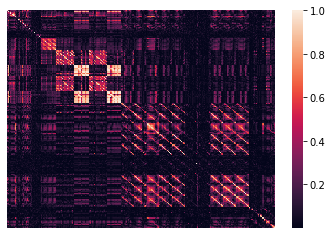

In [140]:
#از ماتریس همبستگی می توان دریافت که برخی از ویژگی ها به شدت با یکدیگر ارتباط دارند. به منظور کاهش ابعاد مسئله ، حذف یکی از دو ویژگی به شدت وابسته (مثبت یا منفی) را انجام میدهم.
corr = pd_speech_features.corr() 
sns.heatmap(np.abs(corr), 
        xticklabels=[],
        yticklabels=[])

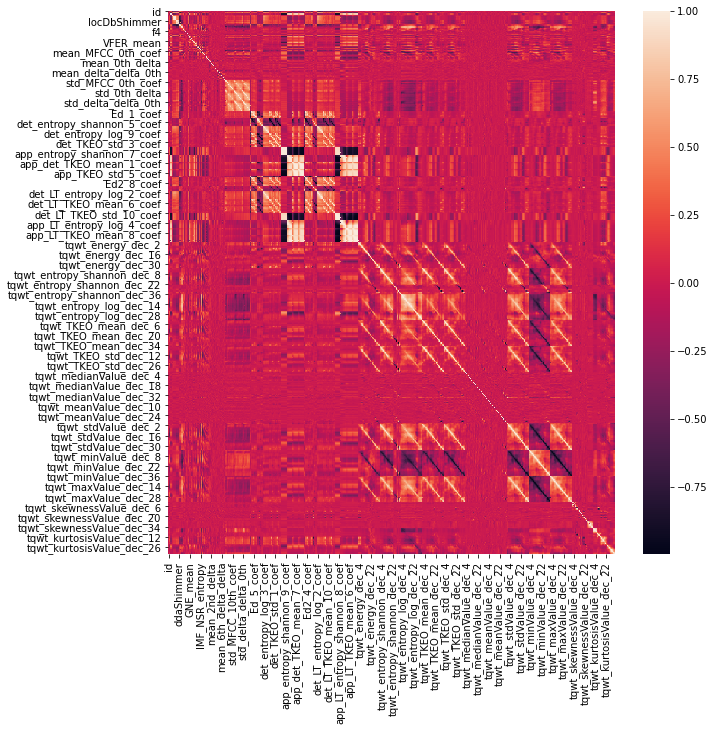

In [141]:
plt.figure(figsize=(10,10))
sns.heatmap(pd_speech_features.corr());

In [142]:
# حذف ویژگی های بشدت وابست
#مانند مقاله حذف ویژگی tqwm
pd_speech_features_no_tqwt = pd_speech_features[pd_speech_features.columns[0: -433]]
pd_speech_features_no_tqwt.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,app_LT_entropy_shannon_1_coef,app_LT_entropy_shannon_2_coef,app_LT_entropy_shannon_3_coef,app_LT_entropy_shannon_4_coef,app_LT_entropy_shannon_5_coef,app_LT_entropy_shannon_6_coef,app_LT_entropy_shannon_7_coef,app_LT_entropy_shannon_8_coef,app_LT_entropy_shannon_9_coef,app_LT_entropy_shannon_10_coef,app_LT_entropy_log_1_coef,app_LT_entropy_log_2_coef,app_LT_entropy_log_3_coef,app_LT_entropy_log_4_coef,app_LT_entropy_log_5_coef,app_LT_entropy_log_6_coef,app_LT_entropy_log_7_coef,app_LT_entropy_log_8_coef,app_LT_entropy_log_9_coef,app_LT_entropy_log_10_coef,app_LT_TKEO_mean_1_coef,app_LT_TKEO_mean_2_coef,app_LT_TKEO_mean_3_coef,app_LT_TKEO_mean_4_coef,app_LT_TKEO_mean_5_coef,app_LT_TKEO_mean_6_coef,app_LT_TKEO_mean_7_coef,app_LT_TKEO_mean_8_coef,app_LT_TKEO_mean_9_coef,app_LT_TKEO_mean_10_coef,app_LT_TKEO_std_1_coef,app_LT_TKEO_std_2_coef,app_LT_TKEO_std_3_coef,app_LT_TKEO_std_4_coef,app_LT_TKEO_std_5_coef,app_LT_TKEO_std_6_coef,app_LT_TKEO_std_7_coef,app_LT_TKEO_std_8_coef,app_LT_TKEO_std_9_coef,app_LT_TKEO_std_10_coef
0,0,1.0,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,...,-19278.0371,-25711.8622,-36938.1370,-57264.6625,-98433.1856,-184901.7535,-381059.3510,-776445.2329,-1676725.978,-3601122.613,414.6434,276.4850,198.5803,153.8978,132.2489,124.1971,127.9812,130.3804,140.7776,151.1748,0.86121,3.0487,9.7825,28.5949,74.3411,174.9214,371.7296,793.0680,1586.1824,3173.0448,6.2990,16.7003,42.0762,101.0889,228.8489,493.8563,1015.7707,2091.9460,4188.2456,8373.9278
1,0,1.0,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363614,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,...,-19028.6532,-25392.0069,-36496.8101,-56599.2563,-97324.8830,-182880.5032,-376979.9939,-768230.2335,-1659120.382,-3563560.603,413.5284,275.8597,198.1971,153.6379,132.0522,124.0327,127.8282,130.2373,140.6345,151.0317,0.85289,3.0213,9.6956,28.3506,73.7185,173.4666,368.5705,786.0763,1572.1837,3144.4525,6.2381,16.5376,41.7306,100.0918,226.9019,489.9169,1006.3702,2074.4541,4148.9889,8298.1606
2,0,1.0,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.15756,0.116890,...,-18926.4578,-25253.6144,-36288.7542,-56258.4752,-96708.1119,-181663.4768,-374463.8517,-763056.6385,-1648032.246,-3539902.400,413.0675,275.5868,198.0149,153.5036,131.9418,123.9329,127.7329,130.1464,140.5436,150.9408,0.84977,3.0062,9.6470,28.2014,73.3297,172.5204,366.5936,782.0604,1564.1081,3128.0295,6.2163,16.4817,41.4869,99.6154,225.7803,486.9865,1001.7348,2064.1067,4127.0967,8254.7868
3,1,0.0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.17295,0

In [143]:
correlation_values=df.corr()['class']
correlation_values.abs().sort_values(ascending=False)

class                       1.000000
mean_MFCC_2nd_coef          0.398695
tqwt_minValue_dec_12        0.395740
tqwt_stdValue_dec_12        0.393029
tqwt_maxValue_dec_12        0.391288
                              ...   
tqwt_skewnessValue_dec_5    0.000783
tqwt_energy_dec_23          0.000463
tqwt_energy_dec_19          0.000343
det_LT_TKEO_mean_1_coef     0.000044
patient/healthy count            NaN
Name: class, Length: 756, dtype: float64

In [144]:
features=df.loc[:,df.columns!='class']
labels=df.loc[:,'class']

In [145]:
print("Samples with label '0': {}\n Samples with label '1': {}".format(labels[labels==0].shape, labels[labels==1].shape))

Samples with label '0': (192,)
 Samples with label '1': (564,)


**XGBoost Classifier**

In [146]:
mm_scaler = MinMaxScaler(feature_range=(-1,1))

In [147]:
X = mm_scaler.fit_transform(features.drop('id', axis=1)) 
y = labels.values

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [149]:
xbg_model = XGBClassifier()
xbg_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [150]:
y_pred = xbg_model.predict(X_test)

In [151]:

    
print(confusion_matrix(y_test, y_pred))

[[ 25  15]
 [  5 107]]


In [152]:
print(accuracy_score(y_test, y_pred))

0.868421052631579


In [153]:
print(precision_score(y_test, y_pred))

0.8770491803278688


In [154]:
print(recall_score(y_test, y_pred))

0.9553571428571429


In [155]:
print(f1_score(y_test, y_pred))

0.9145299145299145


محدوده مجاز: [ 0 784.0 ]


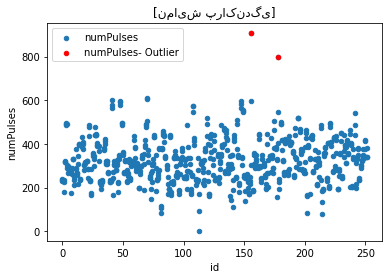

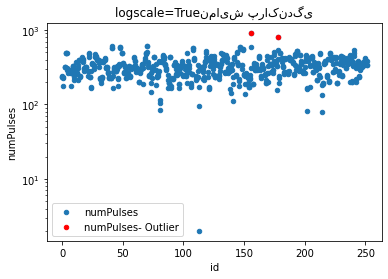

In [156]:
##حذف داده های پرت 
Q1 = np.percentile(pd_speech_features.numPulses, 25)
Q3 = np.percentile(pd_speech_features.numPulses, 75)
    
# پیدا کردن کران مجاز
IQR = Q3 - Q1
low_outlier = max(0, Q1 - 3*IQR)
high_outlier = Q3 + 3*IQR 

print( "محدوده مجاز: [", low_outlier , high_outlier, ']')

# Filter 
df_no_outliers = pd_speech_features[(pd_speech_features.numPulses < high_outlier) | (pd_speech_features.numPulses > low_outlier)]
df_out_outliers = pd_speech_features[(pd_speech_features.numPulses > high_outlier) | (pd_speech_features.numPulses < low_outlier)]

# نمایش پراکندگی
ax =  df_no_outliers.plot.scatter(x='id', y='numPulses', label = 'numPulses')
df_out_outliers.plot.scatter(x='id', y='numPulses', ax=ax, color='red', label = 'numPulses- Outlier')
plt.title('[نمایش پراکندگی]')
plt.show()

#   نمایش پراکندگی وقتی 
# log scale=true
ax =  df_no_outliers.plot.scatter(x='id', y='numPulses', label = 'numPulses', logy=True)
df_out_outliers.plot.scatter(x='id', y='numPulses', ax=ax, color='red', label = 'numPulses- Outlier', logy =True)
plt.title('logscale=Trueنمایش پراکندگی')
plt.show()

**Decision Tree Classifier**

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [158]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [159]:
y_pred = classifier.predict(X_test)

In [160]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[30 12]
 [13 97]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        42
           1       0.89      0.88      0.89       110

    accuracy                           0.84       152
   macro avg       0.79      0.80      0.80       152
weighted avg       0.84      0.84      0.84       152



In [161]:
scores_dict = {'svm' : [],'svm_less_features' : [], 'LR': [], 'LR_less_features': [], 'RF': []}

In [162]:
idx = np.arange(0, len(pd_speech_features) / 3).astype(int)
random_idx = random.sample(range(0, 251), int(len(pd_speech_features) * 0.80 / 3))

train_df = pd_speech_features[pd_speech_features.id.isin(random_idx)]
validation_df = pd_speech_features[np.logical_not(pd_speech_features.id.isin(random_idx))]

train_df_purged = pd_speech_features_no_tqwt[pd_speech_features_no_tqwt.id.isin(random_idx)]
validation_df_purged = pd_speech_features_no_tqwt[np.logical_not(pd_speech_features_no_tqwt.id.isin(random_idx))]

y_train = train_df['class']
y_train = np.array(y_train.values, dtype = 'int')
x_train = train_df.drop(['class'], axis = 1) 

y_validation = validation_df['class']
y_validation = np.array(y_validation.values, dtype = 'int')
x_validation = validation_df.drop(['class'], axis = 1)

**SVM Classifier (with and without cv)**

In [163]:
from sklearn import svm 
from sklearn.model_selection import cross_val_score
y_train = train_df['class']
y_train = np.array(y_train.values, dtype = 'int')
x_train = train_df.drop(['class'], axis = 1) 

y_validation = validation_df['class']
y_validation = np.array(y_validation.values, dtype = 'int')
x_validation = validation_df.drop(['class'], axis = 1) 

clf = svm.SVC(gamma = 0.0001, C=1.0, random_state=None, tol=1e-8)
clf.fit(x_train, y_train)  # no Cross Validation

scores = cross_val_score(clf, x_train, y_train, cv=5) # with 5 fold CV
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

y_prediction = clf.predict(x_validation) 
pred_score = clf.score(x_validation, y_validation)
pred_score

Accuracy: 0.76 (+/- 0.01)


0.7058823529411765

In [164]:
#Confusion Matrics
def compute_confusion_matrix(true, pred):
    K = len(np.unique(true)) # Number of classes 
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result

def compute_accuracy(confusion_matrix, epsilon = 1e-7):
    TP, FP, TN, FN = confusion_matrix_decomposition(confusion_matrix)
    return (TP+TN) / (TP+TN+FP+FN+epsilon) 

def compute_precision(confusion_matrix, epsilon = 1e-7):
    TP, FP, TN, FN = confusion_matrix_decomposition(confusion_matrix)
    return TP / (FP+TP+epsilon)

def compute_f1(confusion_matrix, epsilon = 1e-7):
    TP, FP, TN, FN = confusion_matrix_decomposition(confusion_matrix)
    return  (2*TP) / (2*TP+FP + FN+epsilon) 

def compute_recall(confusion_matrix, epsilon = 1e-7):
    TP, FP, TN, FN = confusion_matrix_decomposition(confusion_matrix)
    return TP / (TP + FN+epsilon)

def confusion_matrix_decomposition(confusion_matrix): 
    TP = confusion_matrix[0,0]
    FP = confusion_matrix[0,1]
    TN = confusion_matrix[1,1]
    FN = confusion_matrix[1,0]
    
    return TP, FP, TN, FN

In [165]:
confusion_matrix = confusion_matrix(y_validation, y_prediction.astype('int'))
print(confusion_matrix)
print('testing accuracy {}'.format(pred_score))

[[  0  45]
 [  0 108]]
testing accuracy 0.7058823529411765


accuracy, precision, F1, recall:

In [166]:
accuracy = compute_accuracy(confusion_matrix)
precision = compute_precision(confusion_matrix)
F1 =  compute_f1(confusion_matrix)
recall = compute_recall(confusion_matrix)

print('accuracy', accuracy)
print('precision', precision)
print('F1', F1)
print('recall', recall)

scores_dict['svm'] = [accuracy,precision, F1, recall]

accuracy 0.7058823524798155
precision 0.0
F1 0.0
recall 0.0


**Random Forest** ***classifier***

In [167]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy') 
classifier.fit(x_train, y_train) 

# predicting the test set result
y_pred_Rforest = classifier.predict(x_validation)

classifier.score(x_validation, y_validation)

0.7777777777777778

In [168]:
scores = cross_val_score(classifier, x_train, y_train, cv=5) # k=5 fold CV
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.06)


In [169]:
max_depth = np.linspace(1, 10, 10).astype(int)
n_estimators = np.linspace(1, 10, 10).astype(int)

accuracy_depth = []
precision_depth = []
f1_score_depth = []
recall_depth = []
    
for depth in tqdm(max_depth): 
    accuracy_estimator = []
    precision_estimator = []
    f1_score_estimator = []
    recall_estimator = []

    for estimator in n_estimators:
              
        classifier = RandomForestClassifier(criterion = 'entropy', max_depth = depth, n_estimators = estimator)
        classifier.fit(x_train, y_train)

        y_pred_Rforest = classifier.predict(x_validation)
        confusion_matrix =compute_confusion_matrix(y_validation, y_pred_Rforest.astype('int'))

        compute_accuracy(confusion_matrix)
        compute_precision(confusion_matrix)
        compute_f1(confusion_matrix)
        compute_recall(confusion_matrix)
            
    accuracy_depth.append(accuracy)
    precision_depth.append(precision)
    f1_score_depth.append(f1_score)
    recall_depth.append(recall)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [170]:
y_pred_Rforest = classifier.predict(x_validation)

In [171]:
classifier.score(x_validation, y_validation)

0.7973856209150327

In [172]:
print(compute_confusion_matrix(y_validation, y_pred_Rforest.astype('int')))
print('Accuracy = ', accuracy_depth)
print('Precision = ', precision_depth)
print('Recall = ', recall_depth)
print('F1 score = ', f1_score_depth)

[[ 19.  26.]
 [  5. 103.]]
Accuracy =  [0.7058823524798155, 0.7058823524798155, 0.7058823524798155, 0.7058823524798155, 0.7058823524798155, 0.7058823524798155, 0.7058823524798155, 0.7058823524798155, 0.7058823524798155, 0.7058823524798155]
Precision =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Recall =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
F1 score =  [<function f1_score at 0x7f0f7bf7a598>, <function f1_score at 0x7f0f7bf7a598>, <function f1_score at 0x7f0f7bf7a598>, <function f1_score at 0x7f0f7bf7a598>, <function f1_score at 0x7f0f7bf7a598>, <function f1_score at 0x7f0f7bf7a598>, <function f1_score at 0x7f0f7bf7a598>, <function f1_score at 0x7f0f7bf7a598>, <function f1_score at 0x7f0f7bf7a598>, <function f1_score at 0x7f0f7bf7a598>]


**مهم ترین ویژگیها بر اساس معیار جینی**

In [173]:
feat_labels = train_df.columns

# نام ویژگی و میزان اهمیت ان بر اساس gini
for feature in zip(feat_labels, classifier.feature_importances_):
    print(feature)

('id', 0.0)
('gender', 0.0)
('PPE', 0.0)
('DFA', 0.0)
('RPDE', 0.0)
('numPulses', 0.0)
('numPeriodsPulses', 0.003115080892327823)
('meanPeriodPulses', 0.0)
('stdDevPeriodPulses', 0.0)
('locPctJitter', 0.0)
('locAbsJitter', 0.0)
('rapJitter', 0.004079053254048613)
('ppq5Jitter', 0.0)
('ddpJitter', 0.006625715717691531)
('locShimmer', 0.0)
('locDbShimmer', 0.00156232493221775)
('apq3Shimmer', 0.0)
('apq5Shimmer', 0.0)
('apq11Shimmer', 0.0)
('ddaShimmer', 0.0018861233546170024)
('meanAutoCorrHarmonicity', 0.0)
('meanNoiseToHarmHarmonicity', 0.0)
('meanHarmToNoiseHarmonicity', 0.0)
('minIntensity', 0.0025108566665521985)
('maxIntensity', 0.0)
('meanIntensity', 0.0015761188969937254)
('f1', 0.0)
('f2', 0.0021078623865826646)
('f3', 0.0)
('f4', 0.0)
('b1', 0.004235175025362817)
('b2', 0.0)
('b3', 0.002940696076487817)
('b4', 0.0)
('GQ_prc5_95', 0.0)
('GQ_std_cycle_open', 0.0)
('GQ_std_cycle_closed', 0.0)
('GNE_mean', 0.0)
('GNE_std', 0.0)
('GNE_SNR_TKEO', 0.0036748722965809257)
('GNE_SNR_SEO